In [ ]:
import cv2
import os
from os import listdir
import sys
import argparse
from posixpath import join
import shutil

import PIL
from PIL import Image
from PIL.ExifTags import TAGS
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Append the directory to your python path
prefix = '/content/drive/My Drive/'
# modify customized_path
customized_path = 'gans_w1/'
sys_path = prefix + customized_path
sys.path.append(sys_path)
print(sys.path)

print('Path to training data: {}'.format(sys_path))

#TODO: Standardize input/output paths to make more sense.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/', '/content/drive/My Drive/gans_w1/']
Path to training data: /content/drive/My Drive/gans_w1/


In [ ]:
input_valid = []
input_heights = []
input_widths = []
input_formats = set()
valid_ext = ['.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp', '.gif',\
               '.eps', '.raw', '.cr2', '.nef', '.orf', '.sr2','.webp']
input_path = os.path.join(sys_path, 'input/')
output_path = os.path.join(sys_path, 'output/')

def walk(input_path, files):
  """
    Searches for and collects directory pathways to files.

    Params:
      input_path: Directory path to input images.
      files: A list to store directory paths to valid files.

    Returns:????
      files: A list of pathways to valid files.
  """
  input_list = os.listdir(input_path)
  for item in input_list:
    if item == '.blurry' or item == '.sharp':
      continue
    if os.path.isdir(os.path.join(input_path,item)):
      walk(os.path.join(input_path, item), files)
    else:
      files.append(os.path.join(input_path, item))

def img_standardize(cur_img, size):
  """
    A function that crops and resizes the image being examined.

    Params:
      im: The image being standardized.
      size: The desired size to which to resize the input image to.
    Returns:
      img: PIL Image object of the standardized image.
  """
  img = Image.open(cur_img)
  width, height = img.size

  if (width > height):
    left_start = (width-height)/2
    img = img.crop((left_start, 0, left_start+height,height))
  elif (height > width):
    top_start = (height-width)/2
    img = img.crop((0, top_start, width, top_start+width))
  img = img.resize((size,size))

  return img

def blur_detection(input_path, thresh=30, split=True, v=True):
  """
    A function that detects and designates images as having an unacceptable
    amount of blurring.

    Params:
      input_path: Directory path to input images.
      thresh: Blurring threshold at which to classify as "blurry."
      split: Boolean denoting whether or nto to copy blurry images into a
        "blurry" subdirectory.
      verbose: Track progress verbosely.

    Returns:
      A list of image NAMES classified as blurry. MAKE PATHS?
  """
  input_list = []
  walk(input_path, input_list)
  input_list.sort()

  if split:
    shutil.rmtree(os.path.join(input_path, '.blurry'))
    shutil.rmtree(os.path.join(input_path, '.sharp'))
    blurry_path = os.path.join(input_path, '.blurry')
    sharp_path = os.path.join(input_path, '.sharp')
    os.makedirs(blurry_path, exist_ok=True)
    os.makedirs(sharp_path, exist_ok=True)

  lpcs = []
  for img_path in input_list:
    img_name = os.path.basename(os.path.normpath(img_path))
    if v:
      print(img_name, img_path)
    try:
      img_cv2 = cv2.imread(img_path)
      img_gray = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2GRAY)
      lpc = cv2.Laplacian(img_gray, cv2.CV_64F).var()
      lpcs.append(lpc)
      if v:
        print(lpc)
      if split:
        if lpc >= thresh:
          cv2.imwrite(os.path.join(sharp_path, img_name), img_cv2)
        else:
          cv2.imwrite(os.path.join(blurry_path, img_name), img_cv2)
    except:
      print("NOTE: " + img_name + " is not an image. Continuing.")

  #return lpcs
  return os.listdir(blurry_path)
    
def reject_image(cur_img, input_path, output_path, size, img_blur_list):
  """
    All-encompassing function handling unusable images. Desired values for
    various thresholds can be tweaked. See: valid extensions, dimension minima,
    and blur threshold.

    Params:
      cur_img: The image to be examined.
      input_path: Directory path to input image folder.
      output_path: Directory path to output image folder.
      size: Desired size for which to qualify minimum size requirements.
      img_blur_list: Given the list of blurry image paths, a reference list
        to which to classify dataset images as blurry.

    Returns: Boolean
      True if the image should be rejected, and False if the image can be used.
  """
  cur_name = os.path.basename(os.path.normpath(cur_img))
  reject_folder = os.path.join(output_path, "rejected")

  #Criteria 1: Is an image
  cur_ext = os.path.splitext(cur_img)[1]
  input_formats.add(cur_ext)

  if cur_ext not in valid_ext:
    print(cur_name, " REJECTED.", " Warning: Not a valid image.")
    shutil.copy(cur_img, reject_folder)
    return True

  #Criteria 2: Sufficiently high resolution
  img = Image.open(cur_img)
  width, height = img.size
  input_valid.append(cur_img)
  input_widths.append(width)
  input_heights.append(height)

  if (width <= 0.8*size) or (height <= int(0.8*size)):
    print(cur_name, " REJECTED.", " Warning: Resolution too low.")
    shutil.copy(cur_img, reject_folder)
    return True

  #Criteria 3: Is not in file path "blurry"
  if cur_name in img_blur_list:
    print(cur_name, " REJECTED.", " Warning: Too blurry.")
    shutil.copy(cur_img, reject_folder)
    return True

  #Usable image
  return False

def writelog(input_list_valid, widths, heights, formats, acc):
  """
    Writes a text file containing statistics about the input dataset.

    Params:
      input_imgs: list of valid input image paths
      widths: list of image widths
      heights: list of image heights
      acc: number of accepted images
      rej: number of rejected images
  """
  num = len(input_list_valid)
  minw = np.min(widths)
  maxw = np.max(widths)
  minh = np.min(heights)
  maxh = np.max(heights)
  avw = np.average(widths)
  avh = np.average(heights)
  rej = num - acc
  percentage = (acc / (acc + rej))

  #Write stuff to file
  log_path = os.path.join(sys_path, '.logs')
  with open(os.path.join(log_path, 'log.txt'), 'w') as f:
    f.write(join("Number of valid images:", str(num)))
    f.write('\n')
    f.write('\n')

    f.write(join('Minimum input width:', str(minw)))
    f.write('\n')
    f.write(join('Maximum input width:', str(maxw)))
    f.write('\n')
    f.write('\n')

    f.write(join('Minimum input height:', str(minh)))
    f.write('\n')    
    f.write(join('Maximum input height:', str(maxh)))
    f.write('\n')
    f.write('\n')

    f.write(join('Average input width:', str(avw)))
    f.write('\n')
    f.write(join('Minimum input width:', str(avh)))
    f.write('\n')
    f.write('\n')

    f.write(join('Percentage of accepted images:', join(str(percentage*100), '%')))
    print('log.txt successfully written.')

def add_entry(img, img_outname, img_dict):
  """
    Adds metadata entry to the metadictionary to be written.

    Params:
      img: The directory path to the image file.
      img_outname: The accepted image's output file name.
      img_dict: The dictionary to which to store metadata in.
  """
  res = Image.open(img).size
  ext = os.path.splitext(img)[1]
  par = os.path.abspath(os.path.join(img, os.pardir))
  img_dict[img_outname]=dict()
  img_dict[img_outname]['original_resolution'] = res
  img_dict[img_outname]['original_format'] = ext
  img_dict[img_outname]['original_path'] = par

#Get blurred image names just once
img_blur_list = blur_detection(input_path, thresh = 60, v=False)

NOTE: spam.txt is not an image. Continuing.


In [ ]:
def pipeline(input_path, output_path, size):
  """
    Given input data files, processes and sorts them according to usability. 
    Main data pipeline function.

    Params:
      input_path: Directory path to input images.
      output_path: Directory path to output images.
      size: Desired length of square output image's edge.
  """
  #img_blur_list = blur_detection(input_path, thresh = 60, v=False)

  img_dict = dict()
  input_imgs = []
  walk(input_path, input_imgs)
  print("NUMBER OF POTENTIAL INPUTS: ", str(len(input_imgs)))

  img_display = []
  img_num = 0
  for img in input_imgs:
    # ~~~~~~~~~~~~~~~~ Start Loop ~~~~~~~~~~~~~~~~
    if reject_image(img, input_path, output_path, size, img_blur_list): continue
    
    cur_name = os.path.basename(os.path.normpath(img))
    img_outname = str(img_num).zfill(6)+'.png'
    print(cur_name, "ACCEPTED")

    #assemble dict ~~~
    add_entry(img, img_outname, img_dict)

    #crop, resize ~~~
    img_standardized = img_standardize(img, size)
    img_display.append(img_standardized)
    
    #copy over edited, accept/reject ~~~
    acc_folder = os.path.join(output_path, "accepted")
    accd_img = os.path.join(acc_folder, img_outname)
    img_standardized.save(accd_img)
    
    #Update valid img number
    img_num += 1
    # ~~~~~~~~~~~~~~~~ End Loop ~~~~~~~~~~~~~~~~

  #save to json to /output ~~~
  try:
    #data_path = os.path.join(sys_path, 'data')
    metadata = open(os.path.join(output_path, 'input_metadata.json'), 'w')
    json.dump(img_dict, metadata, indent=1)
    metadata.close()
    print('input_metadata.json written successfully.')
  except:
    print('Unable to write input_metadata.json.')

  #save log file
  writelog(input_valid, input_widths, input_heights, input_formats, len(img_display))

  # Peek at cropped images
  plt.figure(figsize=(10,10))
  for i in range(len(img_display)):
      plt.subplot(5,5,i+1)
      plt.imshow(img_display[i])
      plt.axis('off')
  plt.show()  
  
  return img_dict

NUMBER OF POTENTIAL INPUTS:  16
Orange_and_white_tabby_cat_with_the_impressive_tail-Hisashi-01A_768b9ad9-5d2e-4eb1-8f0a-6d2b9f0ca7d2_1200x1200.webp ACCEPTED
badcat.jpg  REJECTED.  Warning: Resolution too low.
gato.jpg ACCEPTED
f1f2b6d59171454d74b4f0a6c2146799.jpg ACCEPTED
IMG_6250.jpg  REJECTED.  Warning: Too blurry.
Australian-Shepherd.1.jpg ACCEPTED
American-Pitbull-Puppies-6.JPG_c4357295-9ee4-45f8-9718-e36c98022c46_1200x1200.jpg ACCEPTED
dawg.png ACCEPTED
Screen_Shot_2017-11-22_at_10.34.42_AM.png  REJECTED.  Warning: Too blurry.
hhfhaasgl1i11.webp  REJECTED.  Warning: Too blurry.
chdijwuj7ah21.webp  REJECTED.  Warning: Too blurry.
fishe.jpg ACCEPTED
RY2EpSo74hvYXyAVpTN2Gg-1200-80.jpg ACCEPTED
3245010_3x4.webp  REJECTED.  Warning: Too blurry.
spam.txt  REJECTED.  Warning: Not a valid image.
images-olc-giant_isopod2_600_q85.jpg ACCEPTED
input_metadata.json written successfully.
log.txt successfully written.


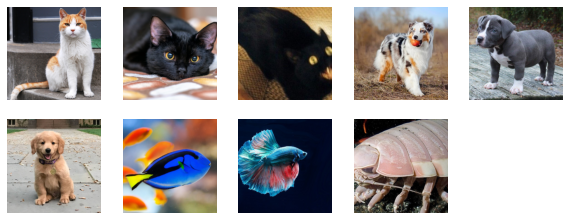

{'000000.png': {'original_resolution': (1000, 1165), 'original_format': '.webp', 'original_path': '/content/drive/My Drive/gans_w1/input/cats'}, '000001.png': {'original_resolution': (2141, 1400), 'original_format': '.jpg', 'original_path': '/content/drive/My Drive/gans_w1/input/cats'}, '000002.png': {'original_resolution': (461, 338), 'original_format': '.jpg', 'original_path': '/content/drive/My Drive/gans_w1/input/cats'}, '000003.png': {'original_resolution': (729, 486), 'original_format': '.jpg', 'original_path': '/content/drive/My Drive/gans_w1/input/dogs'}, '000004.png': {'original_resolution': (1003, 911), 'original_format': '.jpg', 'original_path': '/content/drive/My Drive/gans_w1/input/dogs'}, '000005.png': {'original_resolution': (1920, 1080), 'original_format': '.png', 'original_path': '/content/drive/My Drive/gans_w1/input/dogs'}, '000006.png': {'original_resolution': (600, 600), 'original_format': '.jpg', 'original_path': '/content/drive/My Drive/gans_w1/input/fish'}, '000

In [ ]:
def test_pipeline():
  #5/24: 16 inputs
  #input_path = sys_path + 'input/'
  #output_path = sys_path + 'output/'

  print(pipeline(input_path, output_path, 300))

test_pipeline()

In [ ]:
"""
image = Image.open(img)
    exifdata = image.getexif()
    for tag_id in exifdata:
      tag = TAGS.get(tag_id, tag_id)
      data = exifdata.get(tag_id)
      print(tag)
      if isinstance(data, bytes):
        data = data.decode()
      print(f"{tag:25}: {data}")
"""

'\nimage = Image.open(img)\n    exifdata = image.getexif()\n    for tag_id in exifdata:\n      tag = TAGS.get(tag_id, tag_id)\n      data = exifdata.get(tag_id)\n      print(tag)\n      if isinstance(data, bytes):\n        data = data.decode()\n      print(f"{tag:25}: {data}")\n'